## HDBSCAN Clustering

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
import hdbscan
import statistics

from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from IPython.display  import display_html
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

`Loading data`

In [6]:
digits = load_digits()
data = digits.data


### Dimensionality reduction

We are using TSNE to reduce the 64 dimensions of our dataset to 2 in order to be able to visualize it.

/usr/local/lib/python3.5/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


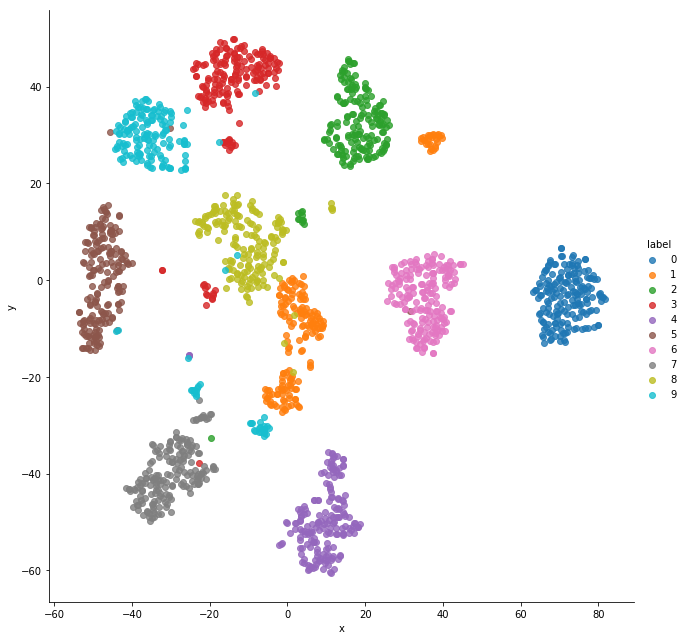

In [7]:
data_embedded = TSNE(n_components = 2, random_state=0).fit_transform(data)
df = pd.DataFrame(data_embedded, columns = ['x','y'])
df['label']= digits.target
sns.lmplot(x= 'x',y= 'y', data= df, fit_reg = False,size=9,hue='label')

In [16]:
clusterer= hdbscan.HDBSCAN(min_cluster_size=12, min_samples=1,prediction_data=True)
clusterer.fit(digits.data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=12, min_samples=1, p=None,
    prediction_data=True)

Text(0, 0.5, 'frequency')

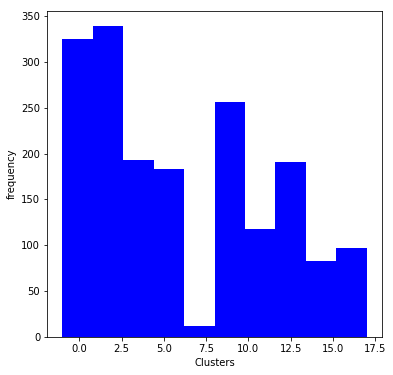

In [17]:
plt.figure(figsize=(6,6))
plt.hist(clusterer.labels_, color = ['blue']);
plt.xlabel('Clusters')
plt.ylabel('frequency')

### Visualizing the clustered data points with a Dendrogram

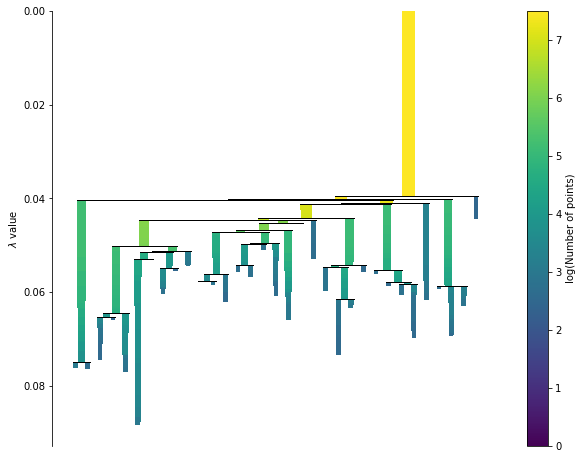

In [18]:
plt.figure(figsize=(10,8))
clusterer.condensed_tree_.plot(log_size=True)

### The circled lines are the  selected clusters by HDBSCAN

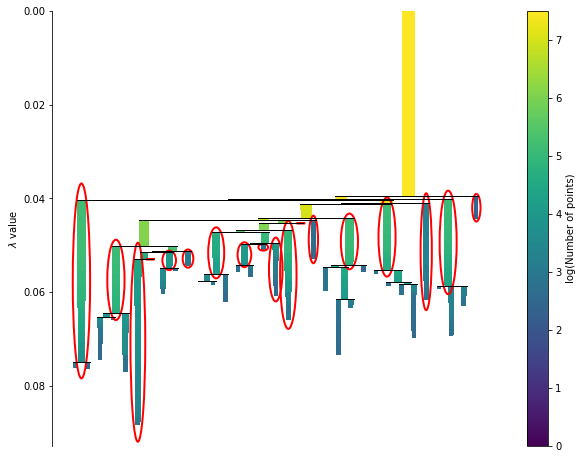

In [19]:
plt.figure(figsize=(10,8))
clusterer.condensed_tree_.plot(log_size=True,select_clusters= True, selection_palette = sns.color_palette())

/usr/local/lib/python3.5/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


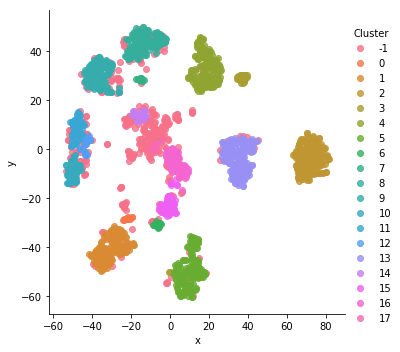

In [20]:
new_df =  pd.DataFrame(data_embedded, columns = ['x','y'])
new_df['Cluster']= clusterer.labels_
color_palette = sns.color_palette("Paired", clusterer.labels_.max()+3)
sns.lmplot(x= 'x',y= 'y', data= new_df, fit_reg = False,hue='Cluster',size=5)


`Looking for the centriod of each cluster.`

In [21]:
def center_point(cluster_label):
    '''
    
    This function is to help find the centriod of a 
    cluster.
    
    Cluster_label is the number assignedf to the cluster
    not the target label.
    
    '''
    
    mem_cluster = digits.images[np.argwhere(clusterer.labels_== cluster_label).reshape(1, -1)[0]]

    check = len(mem_cluster)%2 
    if check == 0:
        centriod = ((mem_cluster[1+round((len(mem_cluster))/2)] + (mem_cluster[round(len(mem_cluster)/2)])))/2
    else:
        centriod = mem_cluster[round((len(mem_cluster)+1)/2)]
    return centriod


`Looking for the average of the points of each cluster`

In [22]:
def average_point(cluster_label):
    '''
    
    This function is to help find the centriod of a 
    cluster.
    
    Cluster_label is the number assignedf to the cluster
    not the target label.
    
    '''
    #mem_cluster= digits.data[np.argwhere(fin_clusterer.labels_==0).reshape(1, -1)[0]]
    #when using digits,data
    mem_cluster = digits.images[np.argwhere(clusterer.labels_== cluster_label).reshape(1, -1)[0]]

    #centriod= np.zeros(64)
    avg = np.zeros(shape=(8,8))
    for i in range(0,len(mem_cluster)):
        avg += mem_cluster[i]
    return(avg/len(mem_cluster))

    

`looking for the most frequent point`

In [23]:
def get_mode(cluster_prob):
        try:
            return statistics.mode(cluster_prob)
        except statistics.StatisticsError:
            rand_choice1 = np.random.randint(len(cluster_prob))
            return rand_choice1

In [24]:
def mode_point(cluster_label):
    index_= np.argwhere(clusterer.labels_== cluster_label).reshape(1, -1)[0]
    prob_cluster = clusterer.probabilities_[[index_]]
    modal_value = get_mode(prob_cluster)
    #modal_value =statistics.mode(prob_cluster)
    modal_freq = len(np.argwhere(prob_cluster == modal_value))
    mem_cluster = digits.images[index_]
    if len(prob_cluster)== modal_freq:
        rand_choice = np.random.randint(modal_freq)
        modal_point  = mem_cluster[rand_choice]
    else:
        modal_point  = mem_cluster[modal_freq]
    return modal_point
    
    
    
    

### Ploting each centriod points 

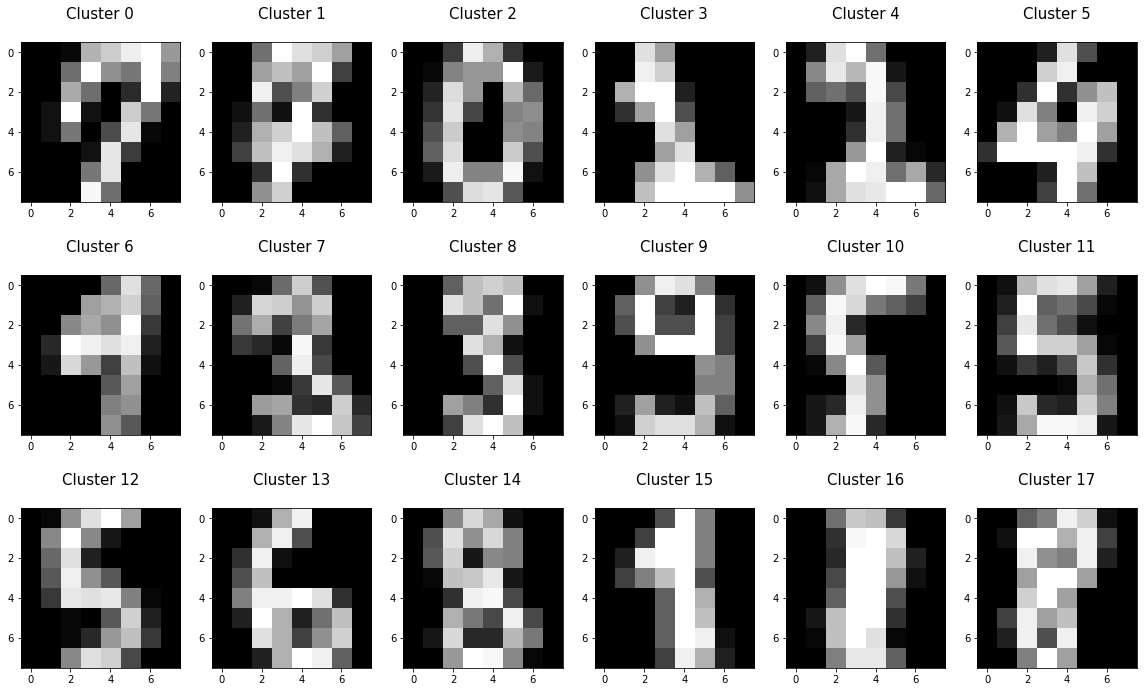

In [25]:
plt.figure(figsize = (20,25))
for j in range(0,clusterer.labels_.max()+1):
    plt.subplot(6,6,j+1)
    plt.imshow(np.reshape(center_point(j), (8,8)),cmap=plt.cm.gray)
    plt.title('Cluster %i\n' % j, fontsize = 15)

### Ploting each average point 

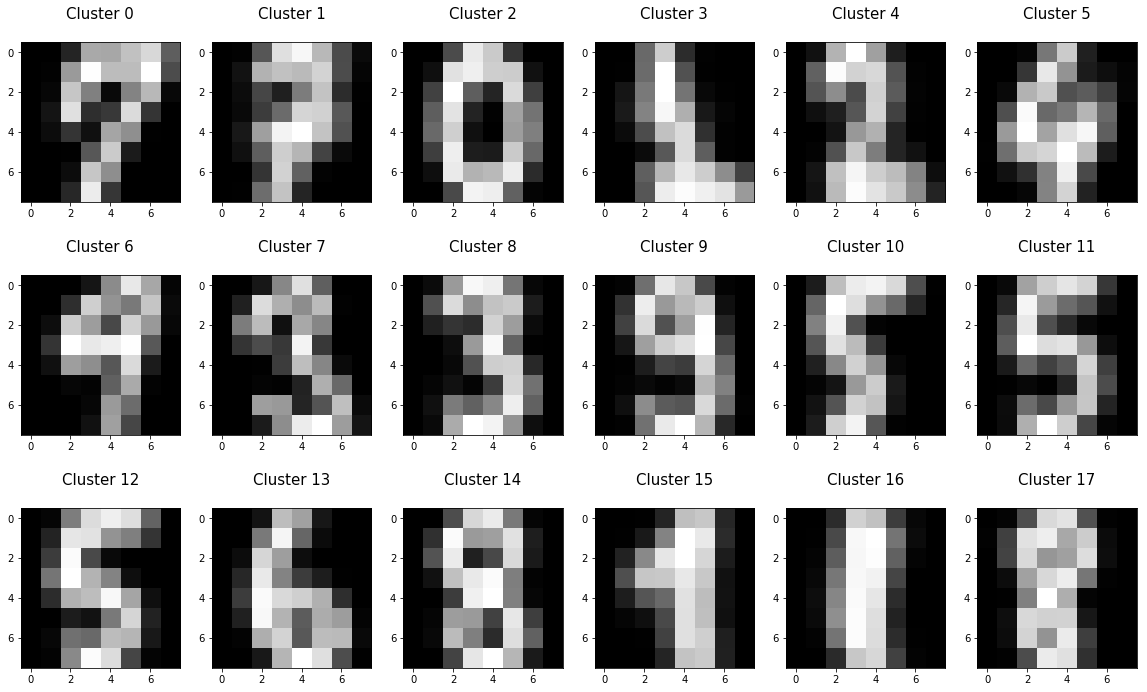

In [26]:
plt.figure(figsize = (20,25))
for j in range(0,clusterer.labels_.max()+1):
    plt.subplot(6,6,j+1)
    plt.imshow(np.reshape(average_point(j), (8,8)),cmap=plt.cm.gray)
    plt.title('Cluster %i\n' % j, fontsize = 15)

### Ploting each modal points 

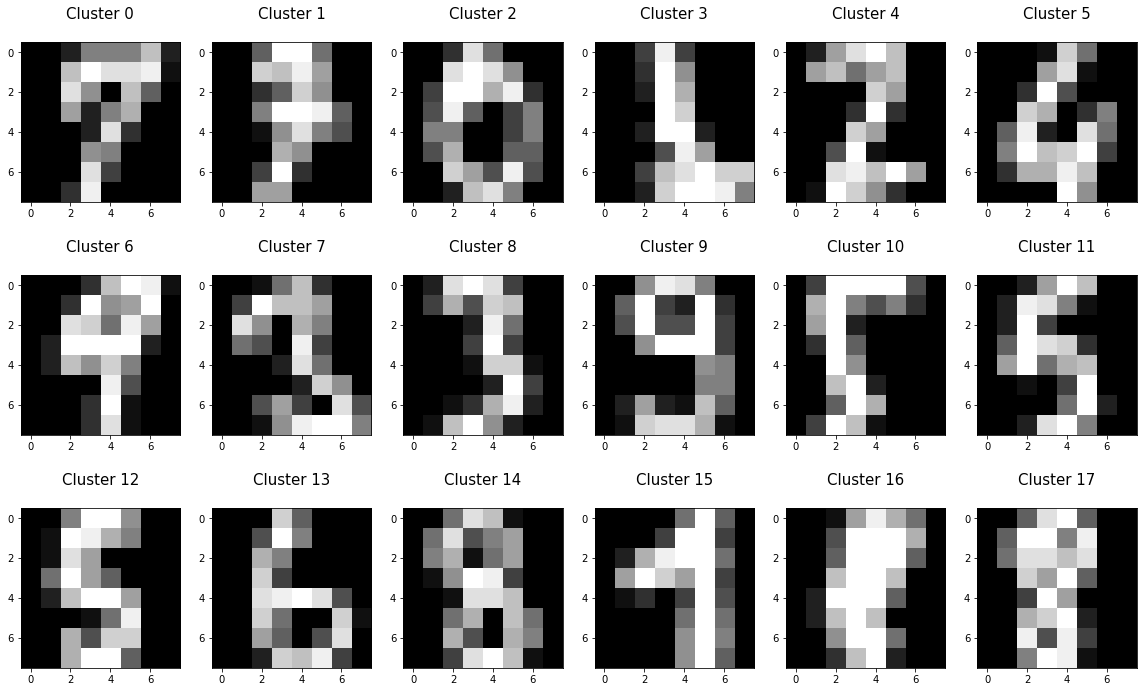

In [16]:
plt.figure(figsize = (20,25))
for j in range(0,clusterer.labels_.max()+1):
    plt.subplot(6,6,j+1)
    plt.imshow(np.reshape(mode_point(j), (8,8)),cmap=plt.cm.gray)
    plt.title('Cluster %i\n' % j, fontsize = 15)

`Clustering noise points`

`The probability of every data point belonging to a cluster is generated and the highest probability is used cluster the noise points`.

In [27]:
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
def cluster_noise_pts():
    nos_clusters = []
    member_prob = soft_clusters[np.argwhere(clusterer.labels_== -1).reshape(1, -1)[0]]
    for j in range(0,len(member_prob)):
        nos_clusters.append(member_prob[j].argmax())
    return nos_clusters


In [28]:
def assign_label(cluster_label):
    label_dict ={'0':7, '1':7, '2':0, '3':1,'4':2,'5':4,'6':9, '7':3, '8':3,'9':9,
                '10':5, '11':5, '12':5, '13':6,'14':8,'15':1,'16':1, '17':8}
    return label_dict.get(str(cluster_label))

In [29]:
def assign_noiselabels():
    label_noise_pt = []
    for i in  cluster_noise_pts():
        label_noise_pt.append(assign_label(i))
    return label_noise_pt


In [132]:
def assign_labels(clusterlabelmax):
    label_cluster = []
    for i in range(-1,clusterlabelmax+1):
        if i == -1:
            label_cluster +=  assign_noiselabels()
        else:
            cluster = digits.images[np.argwhere(clusterer.labels_==i).reshape(1, -1)[0]]
            label_cluster += [assign_label(i)]*len(cluster)
    return np.array(label_cluster)

In [133]:
def corr_cluster_pts(cluster_label):
    points = digits.images[np.argwhere(clusterer.labels_==cluster_label).reshape(1, -1)[0]]
    return points

In [52]:
#digits.images.shape,digits.target.shape, assign_labels(5).shape

((1797, 8, 8), (1797,), (1024,))

In [134]:
def create_newdata():
    i =0
    X = np.array([])
    #Y = np.array([])
    for i in range(-1,clusterer.labels_.max()+1):
        if i==-1:
            #Y=np.copy(assign_labels(i))
            X = np.copy(corr_cluster_pts(i))
        else:
            X=np.append(X, corr_cluster_pts(i), axis=0)
            #Y=np.append(Y, assign_labels(i))
        #X.append(corr_cluster_pts(i))
        #Y.append(assign_labels(i))
    return X

In [135]:
dimages = create_newdata()
dtargets = assign_labels(17)

In [123]:
n_dimages, n_dtargets = shuffle(dimages, dtargets, random_state = 5)

In [125]:
X_train, X_test, Y_train, Y_test = train_test_split(n_dimages, n_dtargets, test_size=0.33, random_state=42)
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(digits.images, digits.target, test_size=0.33, random_state=42)

In [126]:
def selector(y,pos):
    '''
    This function returns the indices
    to  each label
    y : is the array of labels
    pos : is the indicator of the label in the 
    ''' 

    ind = []
    for i in range(10):
        ind.append(np.argwhere(Y_train==i).reshape(1, -1)[0,pos])
    return ind

In [127]:
def Rand_checker(known_list, sample_size, upper_limit):
    '''
    This function generates random numbers
    to be used as subsequence indices for 
    the other sample
    
    know_list : is initial indice list
    
    sample_size : the size of the subsample to be generated
    
    upper_limit : is the len of the array of labels
    '''
    
    Rand_set = []
    while len(Rand_set) < sample_size:
        r = np.random.randint(upper_limit)
        if r not in Rand_set and r not in known_list:
            Rand_set.append(r)
    return Rand_set

In [128]:
def generate_index(known_list, sample_size, upper_limit):
    '''
    This function return the indices  for all
    for all the subsamples to be consider
    
    know_list : is initial indice list
    
    sample_size : the size of the subsample to be generated
    
    upper_limit : is the len of the array of labels
    
    '''
    index_lst=[]
    while len(known_list) < upper_limit:
        if sample_size > upper_limit - len(known_list):
            sample_size = upper_limit - len(known_list)
        index_lst.append(known_list.copy())
        L = Rand_checker(known_list, sample_size, upper_limit)
        known_list.extend(L)
    index_lst.append(known_list.copy())
    return index_lst

 ### Fitting the random forest model to our clustered data.
 
 Making model from the first initial subsample till the final one having step size of 10 increment everytime.

In [129]:
k = generate_index(selector(Y_train,0),10,len(X_train))

accuracy_results=[]
train_interval=[]
for i in k:
    rf_model = RandomForestClassifier(random_state=11)
    x_train = [X_train[j].reshape(64) for j in i]
    rf_model.fit(x_train, Y_train[i])
    train_interval.append(len(i))
    
    # predicting the model for X_test sample 
    
    x_test = [ X_test[l].reshape(64) for l in range(len(X_test))]
    y_predtest = rf_model.predict(x_test)

    # classification accuracy for the test data prediction verses actual

    pred_acc = accuracy_score(y_predtest, Y_test)
    accuracy_results.append(pred_acc)

In [130]:
k = generate_index(selector(Y_train1,0),10,len(X_train1))

accuracy_results1=[]
train_interval1=[]
for i in k:
    rf_model = RandomForestClassifier(random_state=11)
    x_train1 = [X_train1[j].reshape(64) for j in i]
    rf_model.fit(x_train1, Y_train1[i])
    train_interval1.append(len(i))
    
    # predicting the model for X_test sample 
    
    x_test1 = [ X_test1[l].reshape(64) for l in range(len(X_test1))]
    y_predtest1 = rf_model.predict(x_test1)

    # classification accuracy for the test data prediction verses actual

    pred_acc1 = accuracy_score(y_predtest1, Y_test1)
    accuracy_results1.append(pred_acc1)

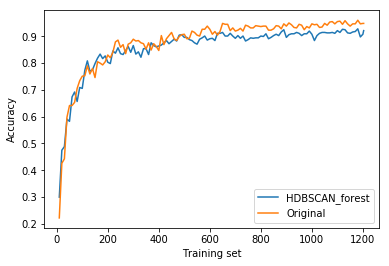

In [136]:
plt.plot(train_interval,accuracy_results, label='HDBSCAN_forest')
plt.plot(train_interval1,accuracy_results1,label = 'Original')
plt.xlabel('Training set')
plt.ylabel('Accuracy')
plt.legend()
plt.show()